In [1]:
# Cellule 1 :  imports 
RANDOM_STATE = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)

from sklearn.inspection import permutation_importance

import lightgbm as lgb
import joblib

pd.set_option("display.max_columns", None)
print("OK imports.")


OK imports.


In [2]:
# Cellule 2 : chargement du csv 

df = pd.read_csv("nhanes_ready.csv")
print(df.shape)
df.head(3)


(6889, 38)


,SEQN,RIDAGEYR,RIAGENDR,LBXTC,BMXHT,BMXBMI,BMXWT,BMXWAIST,BMXARMC,PAD680,SLD012,DRKCAL,DRPROT,DRSUGR,DRFIBE,DRTFAT,DRTALCO,DRCARB,DRWATER,smoker,diabetes,PAD680_log,DRTALCO_log,DRWATER_log,DRSUGR_log,DRFIBE_log,DRCARB_log,DRPROT_log,DRTFAT_log,DRKCAL_log,BMXBMI_log,ethnicity_MexicanAmerican,ethnicity_NonHispanicAsian,ethnicity_NonHispanicBlack,ethnicity_NonHispanicWhite,ethnicity_OtherHispanic,ethnicity_OtherRace,chol_high
0,130378.0,43.0,1,264.0,179.5,27.0,86.9,98.3,35.7,360.0,9.5,1390.0,88.525,22.060,5.95,47.420,2.280000e+01,109.785,1020.0,1,0,5.888878,3.169686e+00,6.928538,3.138100,1.938742,4.707591,4.494518,3.879913,7.237778,3.332205,False,True,False,False,False,False,1
1,130379.0,66.0,1,214.0,174.2,33.5,101.8,114.7,33.7,480.0,9.0,2484.5,82.620,113.495,24.15,73.190,6.030000e+01,280.440,120.0,1,0,6.175867,4.115780e+00,4.795791,4.740531,3.224858,5.639919,4.426283,4.306629,7.818229,3.540959,False,False,False,True,False,False,0
2,130380.0,44.0,2,187.0,152.9,29.7,69.4,93.5,36.3,240.0,8.0,1735.0,67.115,110.920,21.40,55.685,5.397605e-79,245.325,1747.5,0,1,5.484797,5.397605e-79,7.466514,4.717784,3.109061,5.506652,4.221197,4.037510,7.459339,3.424263,False,False,False,False,True,False,0


In [3]:
# Cellule 3 : verification

print("NaN totaux :", df.isna().sum().sum())
print("Doublons   :", df.duplicated().sum())

# Vérification de la cible
print(df["chol_high"].value_counts(dropna=False))
print((df["chol_high"].value_counts(normalize=True)*100).round(2))


NaN totaux : 0
Doublons   : 0
chol_high
0    6272
1     617
Name: count, dtype: int64
chol_high
0    91.04
1     8.96
Name: proportion, dtype: float64


In [4]:
# Cellule 4 — Définition des features


# Paramètre de configuration
USE_ETHNICITY = True   #  passe à False pour entraîner sans les variables ethniques

target = "chol_high"

# Bloc démographie / santé / comportements
core = [
    "RIDAGEYR", "RIAGENDR", "smoker"
]

# Morphologie (réduction volontaire)
morpho = [
    "BMXBMI_log", "BMXWAIST"
]

# Activité / sommeil
lifestyle = [
    "PAD680_log", "SLD012"
]

# Nutrition (moyennes jour1/jour2, log-transformées)
diet = [
    "DRKCAL_log", "DRPROT_log", "DRSUGR_log", "DRFIBE_log",
    "DRTFAT_log", "DRCARB_log", "DRTALCO_log", "DRWATER_log"
]

# Bloc ethnique (6 catégories NHANES)
ethn = [
    "ethnicity_MexicanAmerican",
    "ethnicity_OtherHispanic",
    "ethnicity_NonHispanicWhite",
    "ethnicity_NonHispanicBlack",
    "ethnicity_NonHispanicAsian",
    "ethnicity_OtherRace"
]

# Construction finale
if USE_ETHNICITY:
    features_init = core + morpho + lifestyle + diet + ethn
    print(" Mode avec toutes les ethnies incluses.")
else:
    features_init = core + morpho + lifestyle + diet
    print(" Mode sans aucune variable ethnique.")

# Vérification
missing = [c for c in features_init if c not in df.columns]
if missing:
    print("Colonnes manquantes :", missing)
else:
    print(f"Nombre total de features : {len(features_init)}")

X_full = df[features_init].copy()
y = df[target].astype(int)
print(f"X_full : {X_full.shape}, y pos rate : {y.mean():.3f}")


 Mode avec toutes les ethnies incluses.
Nombre total de features : 21
X_full : (6889, 21), y pos rate : 0.090


In [5]:

# Cellule 5 — Split stratifié train / val / test


# Découpage principal : 80 % pour train+val, 20 % pour test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Sous-découpage : train (60 % du total) / val (20 % du total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25,   # 25 % de 80 % = 20 % du total
    stratify=y_train_full,
    random_state=42
)

# Résumé clair
print("=== Répartition des jeux ===")
print(f"Train : {X_train.shape[0]} ({(X_train.shape[0]/len(X_full))*100:.1f} %)")
print(f"Val   : {X_val.shape[0]} ({(X_val.shape[0]/len(X_full))*100:.1f} %)")
print(f"Test  : {X_test.shape[0]} ({(X_test.shape[0]/len(X_full))*100:.1f} %)")

print("\nRépartition de la variable cible (taux de chol_high=1) :")
print("Train :", y_train.mean().round(3))
print("Val   :", y_val.mean().round(3))
print("Test  :", y_test.mean().round(3))


=== Répartition des jeux ===
Train : 4133 (60.0 %)
Val   : 1378 (20.0 %)
Test  : 1378 (20.0 %)

Répartition de la variable cible (taux de chol_high=1) :
Train : 0.09
Val   : 0.09
Test  : 0.089


In [6]:
# Cellule 6 — Standardisation des variables continues

# Colonnes binaires ou déjà catégorielles (à NE PAS standardiser)
binary_cols = [
    "RIAGENDR", "smoker",
    "ethnicity_MexicanAmerican", "ethnicity_OtherHispanic",
    "ethnicity_NonHispanicWhite", "ethnicity_NonHispanicBlack",
    "ethnicity_NonHispanicAsian", "ethnicity_OtherRace"
] if "ethnicity_MexicanAmerican" in X_train.columns else [
    "RIAGENDR", "smoker"
]

# Variables numériques à standardiser (toutes les autres)
num_cols = [col for col in X_train.columns if col not in binary_cols]

print(f"Colonnes à standardiser : {len(num_cols)} → {num_cols}")

# Initialisation et apprentissage du scaler sur le train uniquement
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Application sur validation et test
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Sauvegarde pour réutilisation (API, déploiement, etc.)
joblib.dump(scaler, "scaler_chol.pkl")

print("Standardisation effectuée sur les variables numériques uniquement.")
print("Scaler sauvegardé sous : scaler_chol.pkl")

# Vérification rapide sur le train
check = pd.DataFrame({
    "mean": X_train[num_cols].mean().round(2),
    "std": X_train[num_cols].std().round(2)
})
print("\n=== Vérification (train) ===")
display(check)


Colonnes à standardiser : 13 → ['RIDAGEYR', 'BMXBMI_log', 'BMXWAIST', 'PAD680_log', 'SLD012', 'DRKCAL_log', 'DRPROT_log', 'DRSUGR_log', 'DRFIBE_log', 'DRTFAT_log', 'DRCARB_log', 'DRTALCO_log', 'DRWATER_log']
Standardisation effectuée sur les variables numériques uniquement.
Scaler sauvegardé sous : scaler_chol.pkl

=== Vérification (train) ===


,mean,std
RIDAGEYR,0.0,1.0
BMXBMI_log,-0.0,1.0
BMXWAIST,0.0,1.0
PAD680_log,-0.0,1.0
SLD012,-0.0,1.0
DRKCAL_log,0.0,1.0
DRPROT_log,0.0,1.0
DRSUGR_log,-0.0,1.0
DRFIBE_log,0.0,1.0
DRTFAT_log,0.0,1.0


In [7]:
# Cellule 7 — Entraînement du modèle LightGBM (baseline, corrigée)

# Modèle LightGBM de base
lgb_base = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)

# Entraînement avec early stopping (sans argument 'verbose')
lgb_base.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=50)  # affiche tous les 50 rounds
    ]
)

# Évaluation sur la validation
y_val_proba = lgb_base.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_val_proba)
print(f" AUC (validation) : {auc_val:.4f}")

# Sauvegarde du modèle
joblib.dump(lgb_base, "model_lightgbm_chol_baseline.pkl")
print("Modèle sauvegardé : model_lightgbm_chol_baseline.pkl")


[LightGBM] [Info] Number of positive: 370, number of negative: 3763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 4133, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.718527	valid_0's binary_logloss: 0.52222
[100]	valid_0's auc: 0.716173	valid_0's binary_logloss: 0.456915
Early stopping, best iteration is:
[38]	valid_0's auc: 0.722729	valid_0's binary_logloss: 0.542585
 AUC (validation) : 0.7227
Modèle sauvegardé : model_lightgbm_chol_baseline.pkl


=== Top 15 variables les plus importantes (gain LightGBM) ===


,gain
BMXWAIST,155
RIDAGEYR,141
BMXBMI_log,135
DRTFAT_log,94
DRSUGR_log,81
DRWATER_log,75
DRCARB_log,72
DRKCAL_log,60
DRFIBE_log,57
PAD680_log,44


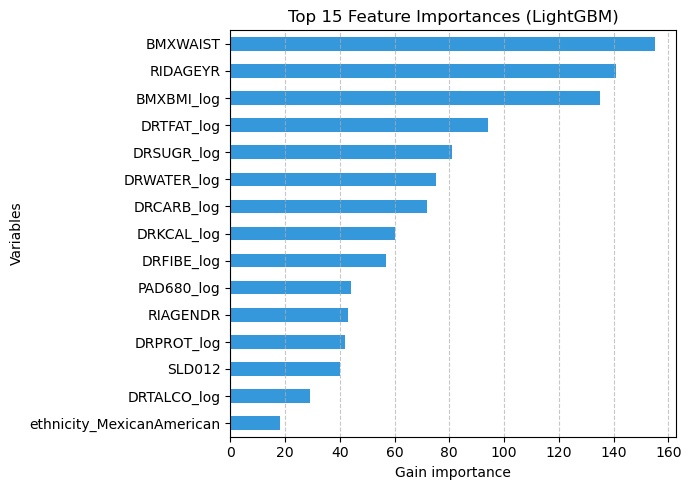

In [8]:
# Cellule 8 — Importance des variables (gain)

# Extraction des importances
importances = pd.Series(
    lgb_base.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Affichage tableau top 15
print("=== Top 15 variables les plus importantes (gain LightGBM) ===")
display(importances.head(15).to_frame("gain"))

# Visualisation graphique
plt.figure(figsize=(7,5))
importances.head(15).sort_values().plot(kind="barh", color="#3498db")
plt.title("Top 15 Feature Importances (LightGBM)")
plt.xlabel("Gain importance")
plt.ylabel("Variables")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


=== RAPPORT DE CLASSIFICATION (TEST) ===
              precision    recall  f1-score   support

           0      0.944     0.697     0.802      1255
           1      0.157     0.577     0.247       123

    accuracy                          0.687      1378
   macro avg      0.551     0.637     0.525      1378
weighted avg      0.874     0.687     0.753      1378

 ROC AUC (test) : 0.7165


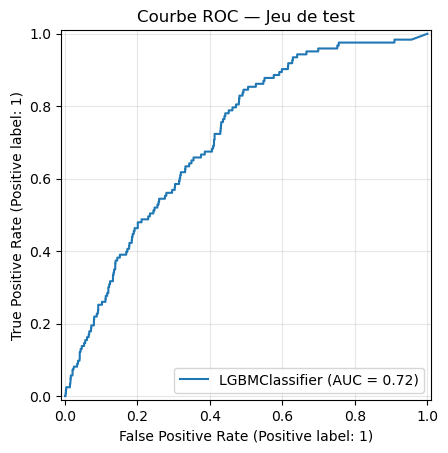

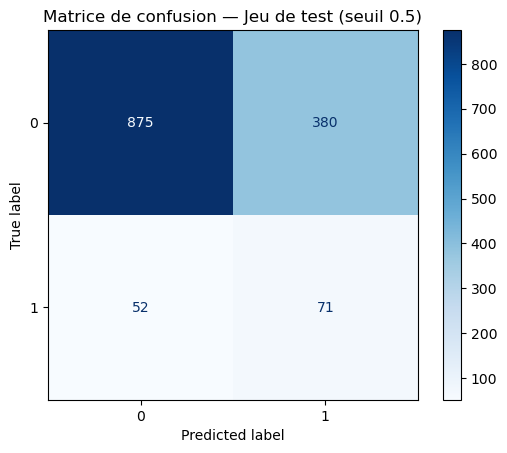

In [9]:
# Cellule 9 — Évaluation finale sur le jeu de test

from sklearn.metrics import confusion_matrix
   
# Prédictions sur le jeu de test
y_test_proba = lgb_base.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

# Rapport complet
print("=== RAPPORT DE CLASSIFICATION (TEST) ===")
print(classification_report(y_test, y_test_pred, digits=3))

# Score global AUC
auc_test = roc_auc_score(y_test, y_test_proba)
print(f" ROC AUC (test) : {auc_test:.4f}")

#  Courbe ROC
RocCurveDisplay.from_estimator(lgb_base, X_test, y_test)
plt.title("Courbe ROC — Jeu de test")
plt.grid(alpha=0.3)
plt.show()

# Matrice de confusion
ConfusionMatrixDisplay.from_estimator(
    lgb_base, X_test, y_test, cmap="Blues", normalize=None
)
plt.title("Matrice de confusion — Jeu de test (seuil 0.5)")
plt.grid(False)
plt.show()


In [10]:
# Cellule 10 — Ajustement du seuil de décision

# Probabilités sur le test
y_scores = lgb_base.predict_proba(X_test)[:, 1]

def eval_threshold(threshold):
    """Affiche les métriques principales pour un seuil donné."""
    y_pred = (y_scores >= threshold).astype(int)
    print(f"\n===== Seuil = {threshold:.2f} =====")
    print(classification_report(y_test, y_pred, digits=3))

# Test de plusieurs seuils
for th in [0.50, 0.45, 0.40, 0.35, 0.30]:
    eval_threshold(th)



===== Seuil = 0.50 =====
              precision    recall  f1-score   support

           0      0.944     0.697     0.802      1255
           1      0.157     0.577     0.247       123

    accuracy                          0.687      1378
   macro avg      0.551     0.637     0.525      1378
weighted avg      0.874     0.687     0.753      1378


===== Seuil = 0.45 =====
              precision    recall  f1-score   support

           0      0.950     0.607     0.741      1255
           1      0.144     0.675     0.237       123

    accuracy                          0.613      1378
   macro avg      0.547     0.641     0.489      1378
weighted avg      0.878     0.613     0.696      1378


===== Seuil = 0.40 =====
              precision    recall  f1-score   support

           0      0.964     0.529     0.683      1255
           1      0.142     0.797     0.241       123

    accuracy                          0.553      1378
   macro avg      0.553     0.663     0.462      1

Average Precision (aire sous courbe PR) : 0.1782


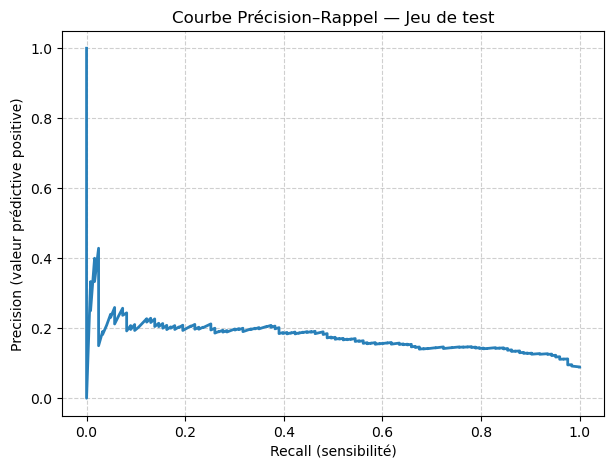

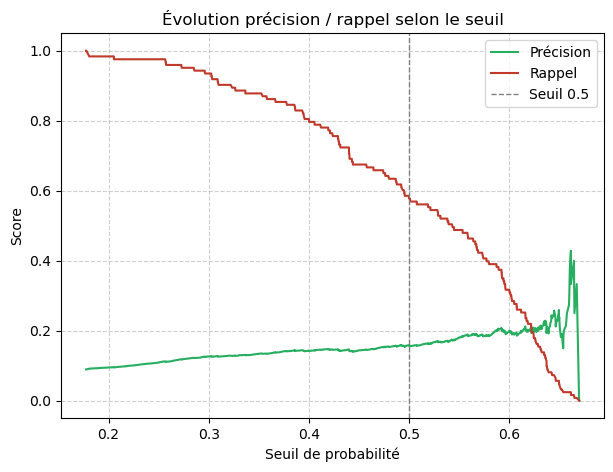

In [11]:
# Cellule 11 — Courbe précision-rappel & seuil optimal

from sklearn.metrics import precision_recall_curve, average_precision_score

# Récupération des probabilités du test
y_scores = lgb_base.predict_proba(X_test)[:, 1]

# Calcul des points de la courbe
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Moyenne pondérée de la précision (aire sous courbe PR)
avg_prec = average_precision_score(y_test, y_scores)
print(f"Average Precision (aire sous courbe PR) : {avg_prec:.4f}")

# --- Courbe précision / rappel ---
plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, color="#2980b9", lw=2)
plt.xlabel("Recall (sensibilité)")
plt.ylabel("Precision (valeur prédictive positive)")
plt.title("Courbe Précision–Rappel — Jeu de test")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --- Précision et rappel selon le seuil ---
plt.figure(figsize=(7,5))
plt.plot(thresholds, precisions[:-1], label="Précision", color="#27ae60")
plt.plot(thresholds, recalls[:-1], label="Rappel", color="#c0392b")
plt.axvline(0.5, color="gray", linestyle="--", lw=1, label="Seuil 0.5")
plt.xlabel("Seuil de probabilité")
plt.ylabel("Score")
plt.title("Évolution précision / rappel selon le seuil")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Seuil optimal : 0.558
   F1-score max  : 0.272
   Précision     : 0.190
   Rappel        : 0.480


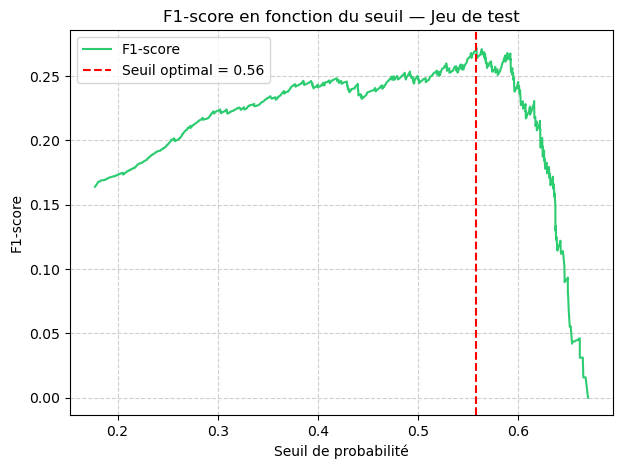

In [12]:
# Cellule 12 — Seuil optimal selon le F1-score

from sklearn.metrics import precision_recall_curve, f1_score

# Probabilités du modèle sur le test
y_scores = lgb_base.predict_proba(X_test)[:, 1]

# Calcul des courbes précision / rappel / seuils
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Calcul du F1-score pour chaque seuil
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Identification du seuil optimal
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Seuil optimal : {best_threshold:.3f}")
print(f"   F1-score max  : {best_f1:.3f}")
print(f"   Précision     : {precisions[best_idx]:.3f}")
print(f"   Rappel        : {recalls[best_idx]:.3f}")

# Visualisation
plt.figure(figsize=(7,5))
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color="#2ecc71")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Seuil optimal = {best_threshold:.2f}")
plt.title("F1-score en fonction du seuil — Jeu de test")
plt.xlabel("Seuil de probabilité")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


=== ÉVALUATION AU SEUIL OPTIMAL (0.56) ===

              precision    recall  f1-score   support

           0      0.940     0.799     0.864      1255
           1      0.190     0.480     0.272       123

    accuracy                          0.771      1378
   macro avg      0.565     0.639     0.568      1378
weighted avg      0.873     0.771     0.811      1378



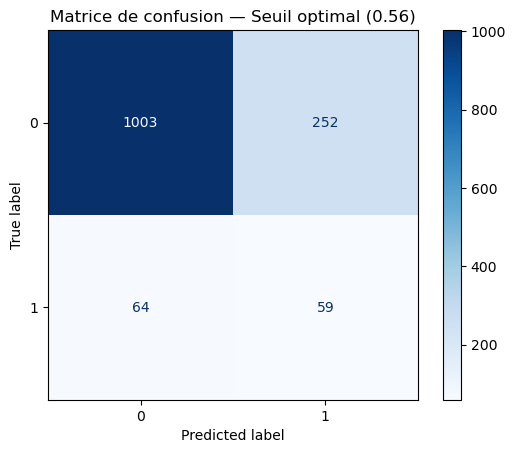

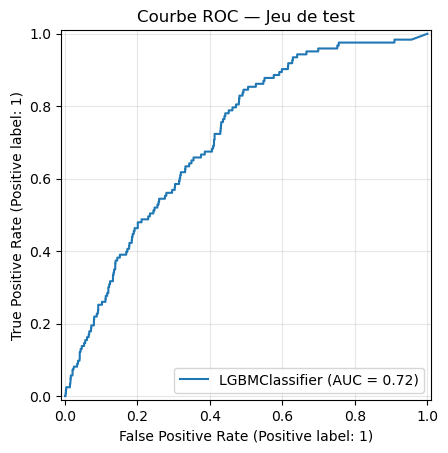

In [13]:
# Cellule 13 — Évaluation complète avec le seuil optimal

# Application du seuil optimal trouvé en cellule 12
y_pred_opt = (y_scores >= best_threshold).astype(int)

print(f"=== ÉVALUATION AU SEUIL OPTIMAL ({best_threshold:.2f}) ===\n")
print(classification_report(y_test, y_pred_opt, digits=3))

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_opt, cmap="Blues", normalize=None
)
plt.title(f"Matrice de confusion — Seuil optimal ({best_threshold:.2f})")
plt.grid(False)
plt.show()

# Courbe ROC pour contexte global
RocCurveDisplay.from_estimator(lgb_base, X_test, y_test)
plt.title("Courbe ROC — Jeu de test")
plt.grid(alpha=0.3)
plt.show()


Nombre de faux positifs : 252
Proportion sur les non-malades : 20.08%


,y_proba,LBXTC
4144,0.669603,177.0
3329,0.669465,142.0
695,0.664807,204.0
2493,0.661331,207.0
6862,0.660177,175.0
2660,0.659678,228.0
3209,0.659678,220.0
2002,0.659330,208.0
3412,0.657303,146.0
1324,0.656801,135.0



=== Distribution du cholestérol (LBXTC) chez les faux positifs ===


,count,mean,std,min,25%,50%,75%,max
LBXTC,252.0,182.583333,32.347666,62.0,164.0,186.5,204.0,240.0


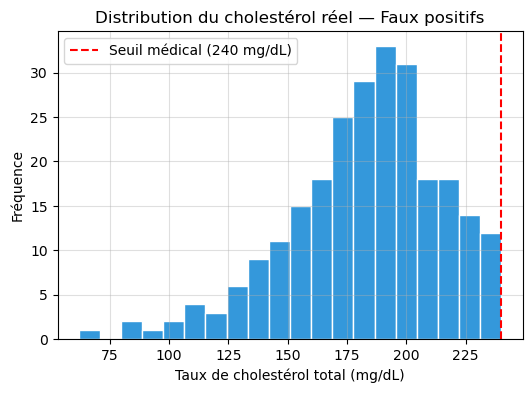

In [14]:
# Cellule 14 — Vérification des faux positifs

# On suppose que df contient bien la colonne LBXTC (taux de cholestérol réel)
# et que l'ordre des indices correspond encore à X_test

# Recréer un DataFrame pour le test set avec prédictions et vérité terrain
df_test = X_test.copy()
df_test["y_true"] = y_test.values
df_test["y_pred"] = y_pred_opt
df_test["y_proba"] = y_scores

# Fusionner avec le cholestérol réel à partir du df d'origine
df_test = df_test.merge(
    df[["LBXTC", "chol_high"]],
    left_index=True, right_index=True, suffixes=("", "_real")
)

# Sélection des faux positifs : vrai = 0, prédit = 1
false_positives = df_test[(df_test["y_true"] == 0) & (df_test["y_pred"] == 1)]

print(f"Nombre de faux positifs : {len(false_positives)}")
print(f"Proportion sur les non-malades : {len(false_positives) / sum(y_test == 0):.2%}")

# Aperçu des 10 premiers faux positifs triés par probabilité prédite
display(false_positives[["y_proba", "LBXTC"]].sort_values(by="y_proba", ascending=False).head(10))

# Statistiques descriptives du cholestérol réel chez ces faux positifs
print("\n=== Distribution du cholestérol (LBXTC) chez les faux positifs ===")
display(false_positives["LBXTC"].describe().to_frame().T)

plt.figure(figsize=(6,4))
plt.hist(false_positives["LBXTC"], bins=20, color="#3498db", edgecolor="white")
plt.axvline(240, color="red", linestyle="--", label="Seuil médical (240 mg/dL)")
plt.xlabel("Taux de cholestérol total (mg/dL)")
plt.ylabel("Fréquence")
plt.title("Distribution du cholestérol réel — Faux positifs")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [15]:
# 1) mêmes longueurs
assert len(X_test) == len(y_test)

# 2) mêmes index (doit être True)
print("Index identiques X_test / y_test :", (X_test.index == y_test.index).all())

# 3) X_test est bien un sous-ensemble indexé de df (doit être True)
print("Index de X_test inclus dans df     :", set(X_test.index).issubset(set(df.index)))


Index identiques X_test / y_test : True
Index de X_test inclus dans df     : True


In [16]:
# ===============================
# Cellule finale — Export complet pour déploiement et traçabilité
# ===============================
import json, time, joblib
from pathlib import Path
import pandas as pd
from sklearn.metrics import roc_auc_score

# === 1. Dossier d'artefacts ===
ART_DIR = Path("artifacts_chol_lgbm")
ART_DIR.mkdir(exist_ok=True)

# === 2. Sauvegarde du modèle et du scaler ===
joblib.dump(lgb_base, ART_DIR / "model_lightgbm_chol_baseline.pkl")
joblib.dump(scaler, ART_DIR / "scaler_chol.pkl")

# === 3. Création du dictionnaire de signature du modèle ===
artifacts = {
    "model_path": str(ART_DIR / "model_lightgbm_chol_baseline.pkl"),
    "scaler_path": str(ART_DIR / "scaler_chol.pkl"),
    "feature_columns": X_train.columns.tolist(),
    "binary_cols": [
        "RIAGENDR", "smoker",
        "ethnicity_MexicanAmerican", "ethnicity_OtherHispanic",
        "ethnicity_NonHispanicWhite", "ethnicity_NonHispanicBlack",
        "ethnicity_NonHispanicAsian", "ethnicity_OtherRace"
    ] if "ethnicity_MexicanAmerican" in X_train.columns else [
        "RIAGENDR", "smoker"
    ],
    "num_cols": [c for c in X_train.columns if c not in [
        "RIAGENDR","smoker",
        "ethnicity_MexicanAmerican","ethnicity_OtherHispanic",
        "ethnicity_NonHispanicWhite","ethnicity_NonHispanicBlack",
        "ethnicity_NonHispanicAsian","ethnicity_OtherRace"
    ]],
    "decision_threshold": float(best_threshold),
    "auc_test": float(roc_auc_score(y_test, y_scores)),
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "framework": "lightgbm",
    "version": "1.0.0"
}

# === 4. Sauvegarde du JSON de signature ===
with open(ART_DIR / "model_signature.json", "w") as f:
    json.dump(artifacts, f, indent=2)

# === 5. Sauvegarde des probabilités du jeu de test ===
df_proba = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": (y_scores >= best_threshold).astype(int),
    "y_proba": y_scores
}, index=X_test.index)

df_proba.to_csv(ART_DIR / "predictions_test_lightgbm.csv", index_label="index")

print(" Export complet terminé.")
print(f"Modèle       : {artifacts['model_path']}")
print(f"Scaler       : {artifacts['scaler_path']}")
print(f"Signature    : {ART_DIR / 'model_signature.json'}")
print(f"Prédictions  : {ART_DIR / 'predictions_test_lightgbm.csv'}")


 Export complet terminé.
Modèle       : artifacts_chol_lgbm\model_lightgbm_chol_baseline.pkl
Scaler       : artifacts_chol_lgbm\scaler_chol.pkl
Signature    : artifacts_chol_lgbm\model_signature.json
Prédictions  : artifacts_chol_lgbm\predictions_test_lightgbm.csv


Nombre de faux négatifs : 64
Proportion sur les malades : 52.03%


,y_proba,LBXTC
6291,0.553202,247.0
4052,0.544545,244.0
3172,0.542627,266.0
2186,0.538992,262.0
1240,0.537982,250.0
5495,0.531031,259.0
6686,0.528640,253.0
1441,0.528076,263.0
4496,0.521032,246.0
5036,0.518639,297.0



=== Distribution du cholestérol (LBXTC) chez les faux négatifs ===


,count,mean,std,min,25%,50%,75%,max
LBXTC,64.0,265.03125,26.274478,241.0,247.75,259.5,270.5,391.0


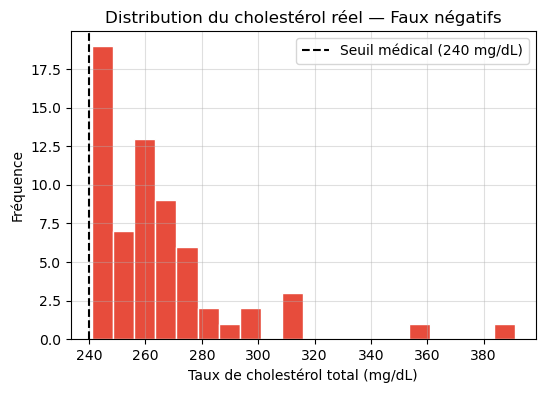

In [17]:
# ===============================
# Cellule — Analyse des faux négatifs
# ===============================

# Sélection des faux négatifs : vrai = 1, prédit = 0
false_negatives = df_test[(df_test["y_true"] == 1) & (df_test["y_pred"] == 0)]

print(f"Nombre de faux négatifs : {len(false_negatives)}")
print(f"Proportion sur les malades : {len(false_negatives) / sum(y_test == 1):.2%}")

# Aperçu des 10 patients malades non détectés (plus fortes proba malgré prédiction négative)
display(false_negatives[["y_proba", "LBXTC"]].sort_values(by="y_proba", ascending=False).head(10))

# Statistiques descriptives du cholestérol réel chez les faux négatifs
print("\n=== Distribution du cholestérol (LBXTC) chez les faux négatifs ===")
display(false_negatives["LBXTC"].describe().to_frame().T)

# Visualisation de la distribution du cholestérol réel
plt.figure(figsize=(6,4))
plt.hist(false_negatives["LBXTC"], bins=20, color="#e74c3c", edgecolor="white")
plt.axvline(240, color="black", linestyle="--", label="Seuil médical (240 mg/dL)")
plt.xlabel("Taux de cholestérol total (mg/dL)")
plt.ylabel("Fréquence")
plt.title("Distribution du cholestérol réel — Faux négatifs")
plt.legend()
plt.grid(alpha=0.4)
plt.show()
